## Modules

In [1]:
from warnings import filterwarnings
#Data wrangling
import pandas as pd
import plotly.express as px
import numpy as np
import datetime

# Data visualization
import cufflinks as cf
import matplotlib.pyplot as plt

# Modeling
from keras import metrics
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from varclushi import VarClusHi
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Environment setupt
cf.set_config_file(theme="white", offline=True)
filterwarnings("ignore")

2023-03-29 08:25:30.269960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 08:25:33.197462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 08:25:33.206800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 08:25:38.138248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def checkDates(data):
    data["Date"]=data["date_rptd"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
    date_index = pd.date_range(start=data["Date"].min(), end=data["Date"].max(), freq="D")
    data = data.set_index("Date").reindex(date_index)
    data.drop(columns=["date_rptd"], inplace=True)
    data.rename(columns={'0': "Crimes"}, inplace= True)
    data["Crimes"]= data["Crimes"].fillna(0)
    return data

## Load data

In [3]:
data= pd.read_csv("Cubo.csv")

In [7]:
data["Date"]=data["Unnamed: 0"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [11]:
data= data.set_index("Date").drop(columns=["Unnamed: 0"])

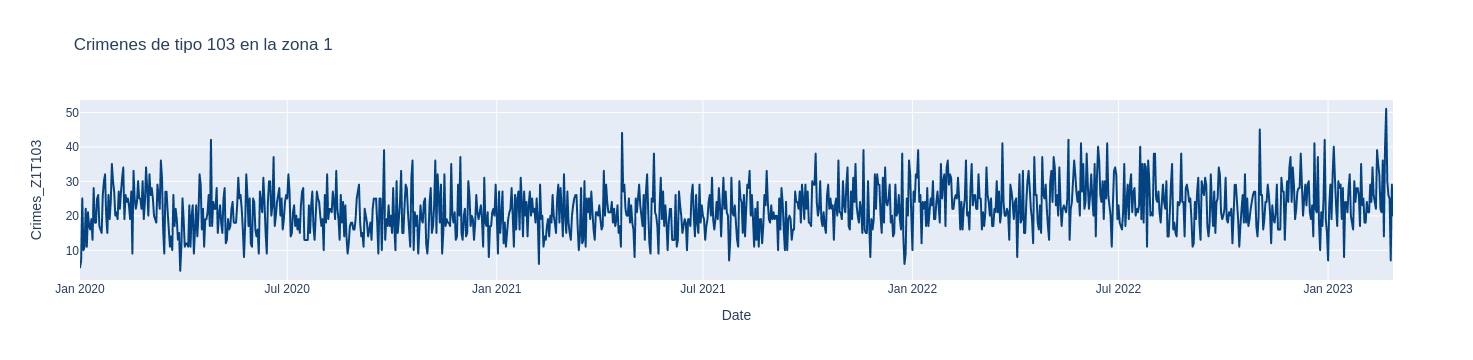

In [14]:
fig = px.line(data, x=data.index, y="Crimes_Z1T103",title=f"Crimenes de tipo 103 en la zona 1")
fig.update_traces(line_color='#044382')
fig.show()

## Feature engineering

In [69]:
df= data.copy()

### Smooting variiables

In [16]:
df["ExponSmoot"] = ExponentialSmoothing(df["Crimes_Z1T103"],trend="add").fit().fittedvalues

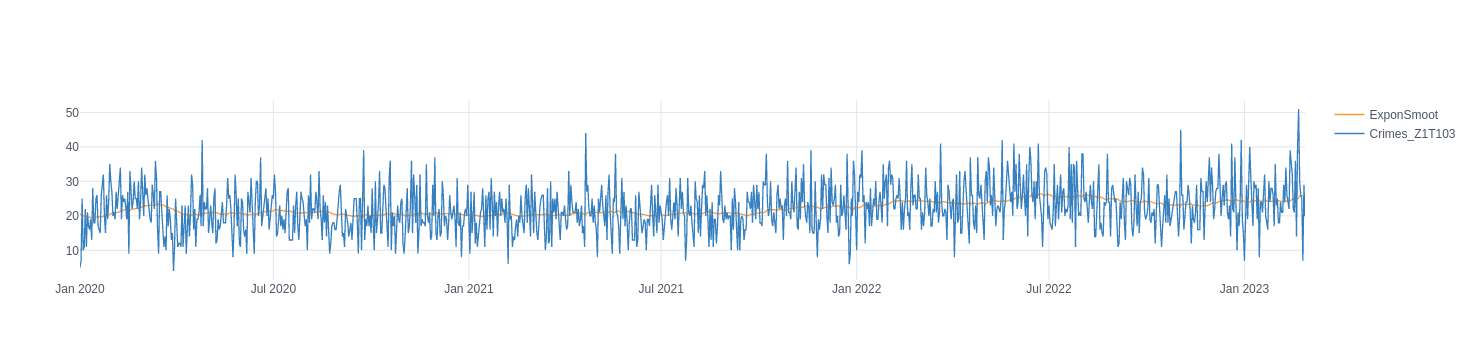

In [19]:
df[["ExponSmoot", "Crimes_Z1T103"]].iplot()

### New variables

In [70]:
ls_features= ["Crimes_Z1T103"]
for i in range(1, 91):
    for feature in ls_features:
        df[f"{feature}(t-{i})"] = df[feature].shift(i)
        df[f"{feature}_diff_{i}"] = df[feature].diff(i)
        df[f"{feature}_pct_{i}"] = df[feature].pct_change(i)
        df[f"{feature}_ma_{i+1}"] = df[feature].rolling(i+1).mean()
        df[f"{feature}_max_{i+1}"] = df[feature].rolling(i+1).max()
        df[f"{feature}_min_{i+1}"] = df[feature].rolling(i+1).min()
        df[f"{feature}_std_{i+1}"] = df[feature].rolling(i+1).std()
        df[f"{feature}_median_{i+1}"] = df[feature].rolling(i+1).median()

### Create target

In [71]:
df["y"]= df["Crimes_Z1T103"].shift(-1)

In [72]:
df.dropna(inplace=True)

In [73]:
df.isna().mean()

Crimes_Z0T100              0.0
Crimes_Z0T101              0.0
Crimes_Z0T102              0.0
Crimes_Z0T103              0.0
Crimes_Z0T104              0.0
                          ... 
Crimes_Z1T103_max_91       0.0
Crimes_Z1T103_min_91       0.0
Crimes_Z1T103_std_91       0.0
Crimes_Z1T103_median_91    0.0
y                          0.0
Length: 746, dtype: float64

## EDA

In [74]:
ls_cont = [x for x in df.columns if x != "y"]

### Outliers

Pendiente, porque realmente es valioso esos casos

### Missings

In [75]:
ls_missing = [x for x, y in df.isna().mean().items() if y > 0.3]

### Unary variables

In [76]:
ls_unary = [x for x, y in df.nunique().items() if y == 1]

### Correlated variables

In [77]:
corr_matrix = df[[x for x in ls_cont if x not in ls_unary+ls_missing]].dropna().corr()

In [78]:
corr_matrix

,Crimes_Z0T100,Crimes_Z0T101,Crimes_Z0T102,Crimes_Z0T103,Crimes_Z0T104,Crimes_Z1T100,Crimes_Z1T101,Crimes_Z1T102,Crimes_Z1T103,Crimes_Z1T104,...,Crimes_Z1T103_std_90,Crimes_Z1T103_median_90,Crimes_Z1T103(t-90),Crimes_Z1T103_diff_90,Crimes_Z1T103_pct_90,Crimes_Z1T103_ma_91,Crimes_Z1T103_max_91,Crimes_Z1T103_min_91,Crimes_Z1T103_std_91,Crimes_Z1T103_median_91
Crimes_Z0T100,1.000000,0.186012,0.005634,0.143946,0.144251,0.204529,0.084094,0.024890,-0.018922,-0.015002,...,-0.043581,0.148686,0.039721,-0.043975,-0.030408,0.147754,0.001352,0.173756,-0.038932,0.144804
Crimes_Z0T101,0.186012,1.000000,0.026353,0.169168,0.146974,0.120276,0.126677,0.038966,0.086771,0.129487,...,-0.108897,-0.081683,0.038708,0.037187,0.015435,-0.099437,-0.037362,-0.052738,-0.113278,-0.080191
Crimes_Z0T102,0.005634,0.026353,1.000000,0.338092,0.369539,0.072549,0.032312,0.749582,0.247601,0.117157,...,0.210179,0.438520,0.141829,0.082748,0.045799,0.432076,0.232876,0.200111,0.208712,0.441257
Crimes_Z0T103,0.143946,0.169168,0.338092,1.000000,0.577450,0.150052,0.096511,0.357621,0.332381,0.313535,...,0.245605,0.490223,0.183350,0.116325,0.071668,0.489559,0.241910,0.242309,0.245437,0.494463
Crimes_Z0T104,0.144251,0.146974,0.369539,0.577450,1.000000,0.131106,0.063930,0.385436,0.321097,0.273939,...,0.222106,0.524946,0.155933,0.128158,0.074246,0.514341,0.234330,0.263928,0.219756,0.528749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Crimes_Z1T103_ma_91,0.147754,-0.099437,0.432076,0.489559,0.514341,0.117044,-0.031644,0.380851,0.276041,0.061639,...,0.624279,0.962829,0.244595,0.027854,0.003772,1.000000,0.443655,0.381433,0.627193,0.959149
Crimes_Z1T103_max_91,0.001352,-0.037362,0.232876,0.241910,0.234330,0.071032,0.000913,0.197940,0.166015,0.014362,...,0.505019,0.422732,0.135413,0.025457,0.004737,0.443655,1.000000,0.243136,0.506471,0.421729
Crimes_Z1T103_min_91,0.173756,-0.052738,0.200111,0.242309,0.263928,0.046718,-0.127003,0.194538,0.076729,-0.094066,...,0.029359,0.296443,0.116046,-0.028046,-0.040991,0.381433,0.243136,1.000000,0.031032,0.301499
Crimes_Z1T103_std_91,-0.038932,-0.113278,0.208712,0.245437,0.219756,0.011032,-0.024179,0.177333,0.178408,0.040962,...,0.995452,0.551239,0.163192,0.014199,0.012226,0.627193,0.506471,0.031032,1.000000,0.543820


In [79]:
ls_checked = []
ls_correlated = []
for i, col in enumerate(corr_matrix.columns):
    ls_checked.append(col)
    ls_correlated += corr_matrix[(corr_matrix[col] == 1) & (~corr_matrix.index.isin(ls_checked))].index.tolist()
ls_correlated = list(set(ls_correlated))

In [80]:
ls_correlated

['Crimes_Z1T103_median_2']

### Remove variables

In [81]:
df = df.drop(columns=ls_unary+ls_missing+ls_correlated)
ls_cont = [x for x in ls_cont if x in df.columns]

## Preprossesing

In [82]:
X= df[ls_cont].copy()

### Imputer

In [83]:
im = SimpleImputer(strategy="median")
Xi = pd.DataFrame(data=im.fit_transform(X), columns=X.columns, index=X.index)

### Scaler

In [84]:
sc = MinMaxScaler()
Xs = pd.DataFrame(data=sc.fit_transform(Xi), columns=Xi.columns, index=Xi.index)

### Multicolineality

In [85]:
vc = VarClusHi(df=Xs, feat_list=Xs.columns, maxclus=10)
vc.varclus()

In [87]:
vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
135,0,Crimes_Z1T103_ma_71,0.970659,0.628949,0.079075
129,0,Crimes_Z1T103_ma_69,0.971212,0.636201,0.079132
132,0,Crimes_Z1T103_ma_70,0.970811,0.631290,0.079166
123,0,Crimes_Z1T103_ma_67,0.971969,0.646182,0.079225
126,0,Crimes_Z1T103_ma_68,0.971574,0.641521,0.079296
...,...,...,...,...,...
663,9,Crimes_Z4T103,0.026355,0.020002,0.993517
662,9,Crimes_Z3T101,0.023314,0.023156,0.999838
659,9,Crimes_Z2T101,0.019868,0.021336,1.001500
661,9,Crimes_Z3T100,0.000351,0.013445,1.013272


In [88]:
res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster"]).first()

In [89]:
res

,Variable,RS_Own,RS_NC,RS_Ratio
Cluster,,,,
0,Crimes_Z1T103_ma_71,0.970659,0.628949,0.079075
1,Crimes_Z1T103_diff_82,0.595636,0.417467,0.694149
2,Crimes_Z1T103_max_64,0.942255,0.517170,0.119596
3,Crimes_Z1T103_min_70,0.934312,0.327350,0.097656
4,Crimes_Z1T103_std_66,0.956681,0.447645,0.078426
5,Crimes_Z1T103_ma_17,0.930758,0.622247,0.183300
6,Crimes_Z1T103_min_28,0.878736,0.288299,0.170386
7,Crimes_Z1T103_std_22,0.885321,0.421241,0.198147
8,Crimes_Z1T103_max_19,0.866402,0.468397,0.251312


In [90]:
bf = [x for x in res["Variable"]]

In [91]:
bf

['Crimes_Z1T103_ma_71',
 'Crimes_Z1T103_diff_82',
 'Crimes_Z1T103_max_64',
 'Crimes_Z1T103_min_70',
 'Crimes_Z1T103_std_66',
 'Crimes_Z1T103_ma_17',
 'Crimes_Z1T103_min_28',
 'Crimes_Z1T103_std_22',
 'Crimes_Z1T103_max_19',
 'Crimes_Z1T103_diff_79']

In [92]:
Xv = Xi[bf].values

### Train test split

In [93]:
y= df[["y"]]
Xt= df[ls_cont]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(Xv, y.interpolate(), test_size=0.3, shuffle=False)

In [95]:
scx= MinMaxScaler()
scy= MinMaxScaler()

In [96]:
X_train= scx.fit_transform(X_train)
y_train= scy.fit_transform(y_train)

In [97]:
X_test= scx.transform(X_test)
y_test= scy.transform(y_test)

In [98]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Model

In [99]:
model = Sequential()

In [100]:
model.add(LSTM(10, input_shape=X_train.shape[1:], activation="tanh", use_bias=False))

model.add(Dense(100, activation="sigmoid",use_bias=False))

model.add(Dense(1, use_bias=False))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                800       
                                                                 
 dense_4 (Dense)             (None, 100)               1000      
                                                                 
 dense_5 (Dense)             (None, 1)                 100       
                                                                 
Total params: 1,900
Trainable params: 1,900
Non-trainable params: 0
_________________________________________________________________


### Metrics

In [101]:
kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
]   

### Callbacks

In [102]:
early_stopping = EarlyStopping(monitor='val_mae', patience=20)

In [103]:
checkpoint = ModelCheckpoint('models/crimes/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

### Setup

In [104]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=kmetrics)

## Training

In [105]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
11/11 [==============================] - 1s 27ms/step - loss: 0.0474 - rms: 0.2178 - mae: 0.1742 - val_loss: 0.0812 - val_rms: 0.2849 - val_mae: 0.2306
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0340 - rms: 0.1843 - mae: 0.1442 - val_loss: 0.0404 - val_rms: 0.2009 - val_mae: 0.1559
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0311 - rms: 0.1762 - mae: 0.1430 - val_loss: 0.0465 - val_rms: 0.2157 - val_mae: 0.1666
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0292 - rms: 0.1709 - mae: 0.1350 - val_loss: 0.0461 - val_rms: 0.2148 - val_mae: 0.1658
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0288 - rms: 0.1698 - mae: 0.1362 - val_loss: 0.0433 - val_rms: 0.2080 - val_mae: 0.1609
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0286 - rms: 0.1692 - mae: 0.1346 - val_loss: 0.0453 - val_rms: 0.2129 - val_mae: 0.1644
Epoch 7/100
11/11 [==

In [106]:
results = pd.DataFrame(history.history)

### Without bias

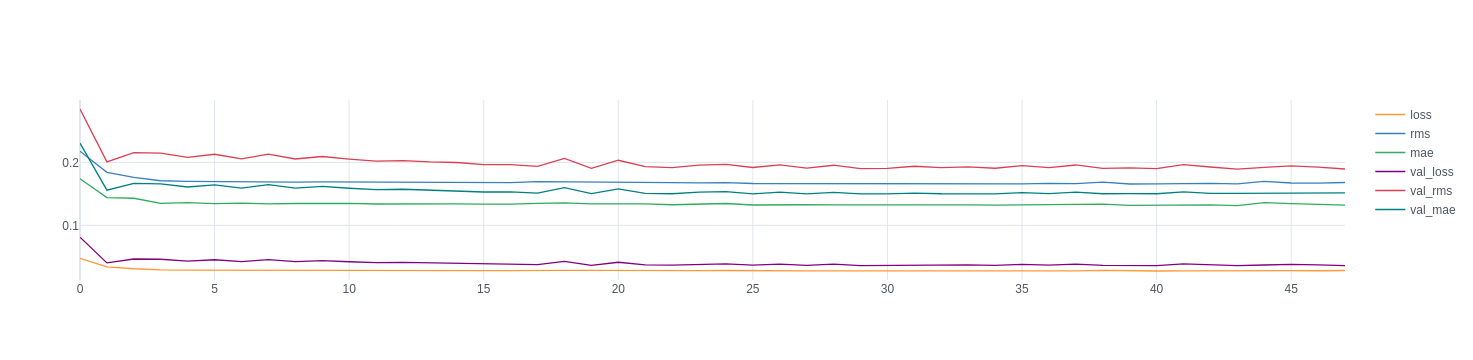

In [107]:
results.iplot()

In [109]:
df["y_hat"] = scy.inverse_transform(model.predict(scx.transform(Xv).reshape(len(Xv), 1, len(bf))))

34/34 [==============================] - 0s 2ms/step


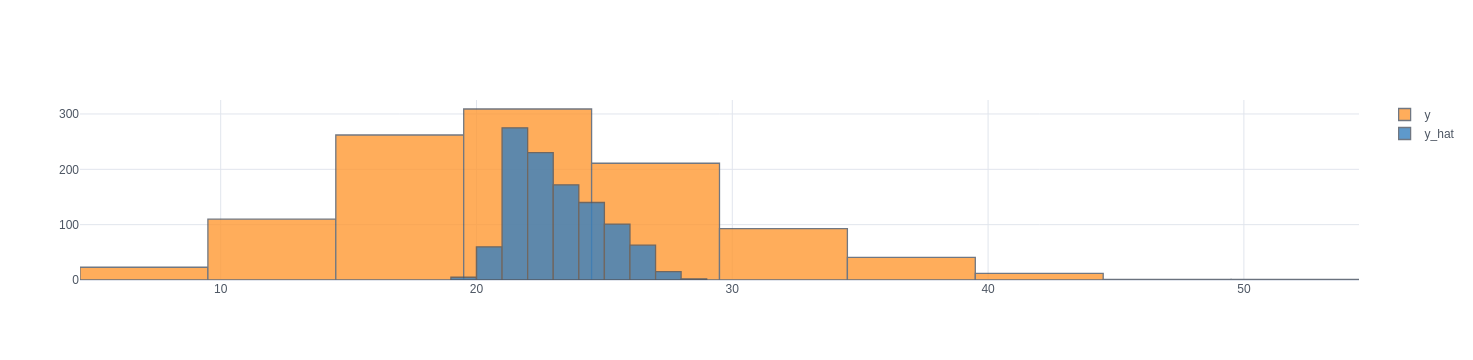

In [110]:
df[["y", "y_hat"]].iplot(kind="hist", bins=10)

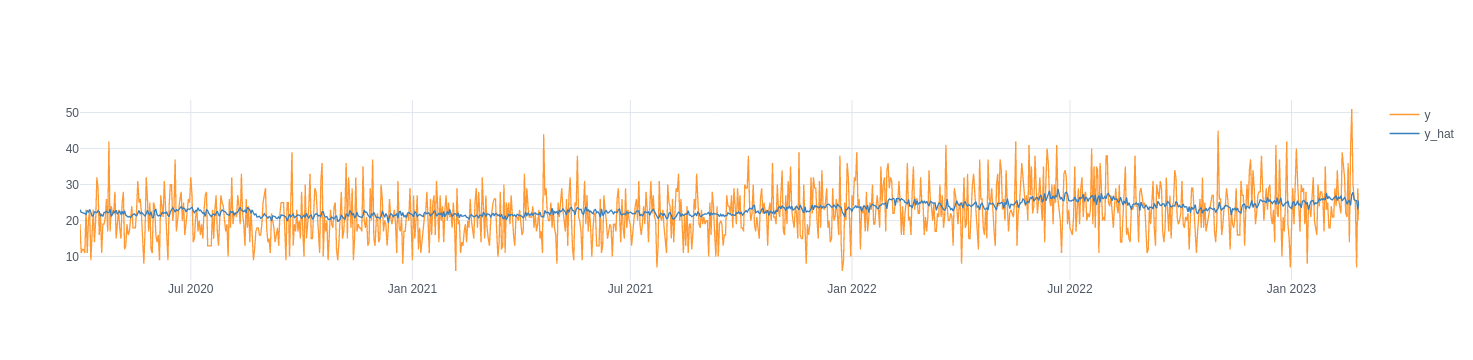

In [111]:
df[["y", "y_hat"]].iplot()

In [112]:
df.iloc[:,-3:]

,Crimes_Z1T103_median_91,y,y_hat
Date,,,
2020-03-31,22.0,19.0,23.059645
2020-04-01,22.0,11.0,22.298784
2020-04-02,22.0,12.0,22.203381
2020-04-03,22.0,12.0,22.146679
2020-04-04,22.0,11.0,21.955194
...,...,...,...
2023-02-22,24.0,26.0,25.865053
2023-02-23,24.0,25.0,25.612705
2023-02-24,25.0,7.0,25.520792


In [97]:
mean_absolute_error(df.iloc[:-1,-3], df.iloc[:-1,-2])

5.001325122604966